In [1]:
%load_ext autoreload
%autoreload 2

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
import io
from tqdm import tqdm
import re


2023-11-27 15:55:46.991277: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 15:55:46.991361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 15:55:46.993475: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 15:55:47.007602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 15:55:50.366126: W tensorflow/compiler/tf2

In [3]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../sympde'))

from misc.utils import get_dict_item, read_lines

In [4]:
def get_data(filter = '', logdir = '../logs', net = 'FNO1d'):
    version_dirs = glob.glob(os.path.join(logdir, net, '*/'))

    data = {'_'.join(os.path.normpath(version_dir).split('/')[-2:]) : {'dir' : version_dir} for version_dir in version_dirs}

    # fitler data.keys() on regex
    pattern = re.compile(filter)
    for key in list(data.keys()):
        if not pattern.search(key):
            data.pop(key)

    return data

In [5]:
def get_results(version_dir, split = 'val'):

    val_loss = []
    val_plot = []
    test_loss = []

    for filename in os.listdir(version_dir):
        if 'events.out.tfevents' in filename:

            file_path = os.path.join(version_dir, filename)
            raw_dataset = tf.data.TFRecordDataset(file_path)

            for raw_record in raw_dataset:
                event = tf.compat.v1.Event.FromString(raw_record.numpy())
                for v in event.summary.value:
                    if v.tag == f'val_loss':
                        val_loss.append(v.simple_value)

                    if v.tag == f'val_plot':
                        image_enc = v.image.encoded_image_string
                        image = Image.open(io.BytesIO(image_enc))
                        val_plot.append(image)

                    if v.tag == f'test_loss':
                        test_loss.append(v.simple_value)
    
    val_loss = np.array(val_loss)
    test_loss = np.array(test_loss)
    return val_loss, val_plot, test_loss

def get_color(version):
    if 'aug0' in version:
        return 'tab:blue'
    elif 'aug1' in version:
        return 'tab:orange'
    else:
        return 'tab:green'

In [6]:
def get_metrics(data):
    for version, version_dict in tqdm(data.items()):
        version_dict['val_loss'], version_dict['val_plot'], version_dict['test_loss'] = get_results(version_dict['dir'])
        version_dict['color'] = get_color(version)
    return data

In [7]:
def plot_testloss(data, print_loss = False):
    plt.style.use('default')

    test_loss_noaug = np.array([v['test_loss'][0] for k, v in data.items() if 'aug0' in k and len(v['test_loss']) > 0]).flatten()
    test_loss_aug   = np.array([v['test_loss'][0] for k, v in data.items() if 'aug1' in k and len(v['test_loss']) > 0]).flatten()

    if print_loss:
        print('No Aug: ', test_loss_noaug)
        print('Aug:    ', test_loss_aug)

    plt.figure(figsize=(3,4))
    bins = None
    plt.hist(test_loss_noaug, label='No Aug', alpha = 0.5, bins = bins, color = 'tab:blue')
    # _, bins, _ = plt.hist(test_loss_noaug, label='No Aug', alpha = 0.5, bins = bins, color = 'tab:blue')
    plt.hist(test_loss_aug, label='Aug', alpha = 0.5, bins = bins, color = 'tab:orange')
    plt.legend()
    plt.show()

In [8]:
def parse_arguments_to_dict(arg_list):
    """
    Parses a list of argument strings into a list of dictionaries.

    Each string in the list is expected to have a format like '--key value',
    and this function will convert these strings into dictionaries where
    each key-value pair is an entry.

    :param arg_list: List of argument strings.
    :return: List of dictionaries with parsed key-value pairs.
    """
    parsed_list = []

    for arg_str in arg_list:
        # Split the string into individual arguments
        args = arg_str.strip().split('--')
        args_dict = {}

        for arg in args:
            if arg:
                # Split each argument into key and value
                key, value = arg.strip().split(maxsplit=1)
                args_dict[key] = value

        parsed_list.append(args_dict)

    return parsed_list

In [9]:
# hparams = read_lines('../jobs/array_train_hparams.txt')
# hparams = parse_arguments_to_dict(hparams)
# hparams

In [10]:
# for hparam in hparams:
#     filter = f"optim{hparam['optimizer']}_lr{float(hparam['lr'])}_scheduler{hparam['scheduler']}"

#     print(filter)
#     data = get_data(filter = filter)
#     data = get_metrics(data)
#     plot_testloss(data, print_loss = True)

100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


No Aug:  [0.1276679  0.11419304 0.11804436 0.10815229 0.10159767]
Aug:     [0.07190586 0.10236023 0.09672485 0.17241299 0.14906992]


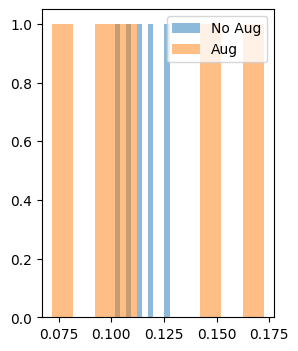

In [13]:
data = get_data(filter = 'precision')
data = get_metrics(data)
plot_testloss(data, print_loss = True)

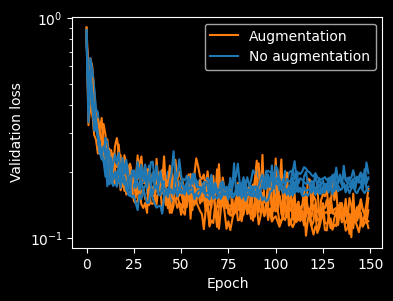

In [14]:
plt.style.use('dark_background')


fig, axs = plt.subplots(1, 1, figsize=(4, 3))
for version, version_dict in data.items():

    if version[-1] ==  get_dict_item(data)[0][-1]:
        if 'aug1' in version:
            label = 'Augmentation'
        elif 'aug0' in version:
            label = 'No augmentation'
    else:
        label = ''

    axs.plot(version_dict['val_loss'], label=label, color=version_dict['color'])
axs.set_xlabel('Epoch')
axs.set_ylabel('Validation loss')
axs.set_yscale('log')
axs.legend()
plt.show()

### More plots

In [93]:
a = True
if a is None:
    print('a is None')

In [ ]:
assert False

AssertionError: 

In [ ]:
# keys = ['FNO1d_aug0_KdV_seed1', 'FNO1d_aug1_KdV_seed1']
# for key in keys:
#     images = data[key]['val_plot']
#     im = images[-1]
#     plt.figure(tight_layout=True)
#     plt.imshow(im)
#     plt.axis('off')
#     plt.show()